### Corrigé du Projet précédent :

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline 
plt.rcParams["figure.figsize"] = (3,3)
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp

def predict_euler_explicit(f, x0, dt, t0, tf):
    t, x = t0, x0
    while t < tf:
        t_next, x_next = t + dt, x + dt * f(t,x)
        t, x = t_next, x_next
    return x


#predict_euler_explicit = np.vectorize(predict_euler_explicit, excluded=['f',"dt","t0","tf"], signature = "(),(m,n),(),(),()->(m,n)")


# Suivi de position en mer (suite probabiliste)

Ce projet suit directement le travail réalisé dans le projet d'équations différentielles. Vous êtes libres d'utiliser la correction ou bien vos propres fonctions.
L'objectif est d'illustrer comment les méthodes probabilistes vont nous permettre d'associer une incertitude aux variables d'état estimées, notamment lorsque les observations ne sont pas disponibles à la même fréquence temporelle que le pas de discrétisation du modèle numérique.

## Filtrage de Kalman probabiliste

On considère un modèle dynamique discret, dit *espace-état probabiliste* linéaire de la forme suivante :
\begin{align*}
X_t &= A X_{t-1} + \varepsilon_t\\
Y_t &= B X_t + \eta_t
\end{align*}
où $X_t$ est un vecteur aléatoire de $\mathbb{R}^n$ qui représente l'état du système au temps $t$, $\varepsilon_t$ est un vecteur aléatoire de $\mathbb{R}^n$ qui représente l'erreur de modélisation au temps $t$, $A$ est la matrice d'évolution ou de transition du système, $Y_t \in \mathbb{R}^d$ est l'observation au temps $t$, avec $B$ la matrice d'observation et $\eta_t\in \mathbb{R}^d$ l'erreur d'observation au temps $t$. On suppose connue la loi de $X_0$ et que les erreurs sont indépendantes de l'état du système.

La première équation sera dite d'évolution et la seconde d'observation. 

### Construction du filtre de Kalman probabiliste (cas linéaire)

**Question 1.** Sous l'hypothèse que $\varepsilon_t \sim \mathcal{N}(0,Q)$ et $\eta_t\sim\mathcal{N}(0,R)$, avec $Q$ et $R$ des matrices symétriques définies positives, montrer qu'on peut réécrire ces deux équations sous la forme :
\begin{align*}
X_t| X_{t-1} =x_{t-1} &\sim \mathcal{N}(A x_{t-1}, Q)\\
Y_t| X_t= x_t &\sim \mathcal{N}(B x_t, R)
\end{align*}


On rappelle qu'une combinaison linéaire de variables gaussiennes suit une loi gaussienne qui est entièrement déterminée par ses moments d'ordre 1 et 2 (espérance et matrice de covariance).

**Question 2.** En supposant que $X_0 \sim \mathcal{N}(m_0,P_0)$, montrer que 
\begin{align*}
X_1 &\sim \mathcal{N}(m_1 = A m_0,P_1 = A P_0 A^t + Q)\\ 
\text{puis que } X_1|Y_1 = y_1 &\sim \mathcal{N}(m_1+P_1 B^t (B P_1 B^t +R)^{-1}(y_1 - B m_1),P_1 - P_1 B^t(B P_1 B^t +R)^{-1}B P_1).
\end{align*} 
On pourra exprimer la loi du vecteur $(X_1,Y_1)$.

On peut itérer le procédé et résumer comme suit les deux étapes du filtre de Kalman :

* Etape de prédiction : 
\begin{align*}
m_t^p &= A m_{t-1} \\
P_t^p &= A P_{t} A^t + Q
\end{align*}

* Etape de mise à jour :
\begin{align*}
m_t &= m_t^p+P_t^p B^t (B P_t^p B^t +R)^{-1}(y_1 - B m_t^p)\\
P_t &= P_t^p - P_t^p B^t(B P_t^p B^t +R)^{-1}B P_t^p \\
\end{align*}

Autrement dit, on fait d'abord évoluer le système selon sa dynamique, puis on le conditionne aux nouvelles observations. L'estimateur de l'état est donné par $m_t = \mathbb{E}(X_t|X_{t-1} =x_{t-1},Y_t = y_t)$ qui est la meilleure approximation de $X_t$ au sens des moindres carrés sachant $X_{t-1} = x_{t-1}$ et $Y_t = y_{t-1}$ (voir chapitre 3 du cours de Probabilités).

L'interprétation probabiliste nous permet en outre d'associer à cet estimateur la loi de probabilité $\mathcal{N}(m_t,P_t)$.

### Application au suivi de la trajectoire du bateau - Filtre de Kalman étendu

Les développements ci-dessus permettent de donner une interprétation probabiliste aux résultats obtenus dans le projet d'équations différentielles. Dans le paragraphe précédent, nous avons décrit le filtre de Kalman dans le cas d'une dynamique linéaire. Dans le cas de la trajectoire du bateau cependant, l'évolution de la position est une fonction non-linéaire des composantes du vecteur d'état. Pour qu'il soit applicable, la version étendue du filtre de Kalman a été implémentée. On peut la résumer en les deux étapes suivantes :

* Etape de prédiction : 
\begin{align*}
m_t^p &= f(t,m_{t-1}) \\
P_t^p &= A_t P_{t-1} A_t^t + Q
\end{align*}

* Etape de mise à jour :
\begin{align*}
m_t &= m_t^p+P_t^p B^t (B P_t^p B^t +R)^{-1}(y_1 - B m_t^p)\\
P_t &= P_t^p - P_t^p B^t(B P_t^p B^t +R)^{-1}B P_t^p \\
\end{align*}

La différence avec le cas linéaire est que la dynamique est non linéaire cependant, pour propager les matrices de covariances et maintenir la loi gaussienne, la dynamique est linéarisée. Ainsi, on utilise
\begin{align*}
A_t = \frac{\partial f}{\partial x}(t,m_t) \\
B_t = \frac{\partial h}{\partial x}(t,m_t) \\
\end{align*}

C'est le filtre de Kalman étendu qui a été implémenté dans le projet d'équations différentielles.

**Question 3.** Interpréter les différentes quantités entrant dans la construction du filtre de Kalman étendu de manière probabiliste en précisant les hypothèses ou approximations effectuées. Proposer une "zone" de confiance à 95% autour du dernier point de la trajectoire. Que se passe-t-il lorsque le pas de discrétisation augmente ?

## Filtrage particulaire

En raison de la contrainte ou de l'approximation linéaire imposée, l'emploi du filtre de Kalman est limitant lorsque la dynamique est fortement non linéaire et/ou lorsque la fréquence d'observation est faible en regard de la dynamique. On peut voir qu'il est en réalité une solution particulière au problème de filtrage bayésien que nous nous proposons maintenant d'étudier.

### Filtrage bayésien

On considère maintenant un modèle espace-état plus général de la forme suivante :

\begin{align*}
X_t &= f(X_{t-1},\varepsilon_t),\\
Y_t &= h(X_t,\eta_t),
\end{align*}

avec les mêmes notations que dans la partie précédente. $f$ et $h$ représentent désormais respectivement une dynamique et une fonction d'observation possiblement non-linéaires. A noter que les erreurs ne sont plus nécessairement additives. De même que précédemment, on supposera que $X_0$ est de loi de probabilité connue. On suppose que tous les vecteurs aléatoires admettent des densités.

On peut remarquer dans un premier temps que la loi de $X_t|X_{t-1} = x_{t-1}, \ldots, X_0 = x_0$ est identique à la loi de $X_t|X_{t-1} = x_{t-1}$, en d'autres termes que la loi de $X_t$ sachant tous les points précédents de la trajectoire est entièrement caractérisée par la connaissance de $X_{t-1} = x_{t-1}$. En terme de densités de probabilités, on a :
\begin{equation*}
f_{X_t|X_{t-1} = x_{t-1}, \ldots, X_0 = x_0}(x) = f_{X_t|X_{t-1} = x_{t-1}}(x).
\end{equation*}
On appelle cette propriété la *propriété de Markov*. De plus, de manière évidente, on a :
\begin{equation*}
f_{Y_t|X_t = x_t, Y_{t-1} = y_{t-1}, \ldots, Y_0 = y_0}(y) = f_{Y_t|X_t = x_t}(y),
\end{equation*}
ce qui signifie que l'observation au temps $t$ est *conditionnellement indépendante* des observations passées, sachant $X_t = x_t$.

Dans ce cadre, on va chercher à caractériser la loi de la séquence $X_{1:T} = (X_1,\ldots,X_T)$ (la *trajectoire* de l'état du système), sachant les observations $Y_{1:T} = (Y_1,\ldots,Y_T)$, où plus simplement la loi de l'état du système à l'instant $t$ $X_t$ sachant les observations $Y_{1:t}$.


**Question 1.** En utilisant la propriété de Markov et la formule de Bayes, montrer que :
\begin{equation*}
f_{X_{1:t}|Y_{1:t}=y_{1:t}}(x_{1:t}) = \frac{f_{Y_t|X_t = x_t}(y_t) f_{X_t|X_{t-1}=x_{t-1}}(x_t)f_{X_{1:t-1}|Y_{1:t-1}=y_{1:t-1}}(x_{1:t-1})}{f_{Y_t|Y_{t-1} = y_{t-1}, \ldots, Y_0 = y_0}(y_t)}
\end{equation*}

Cette expression nous montre qu'on peut décomposer séquentiellement la loi conditionnelle de la trajectoire sachant les observations, autrement dit que l'on peut la mettre à jour itérativement.

**Question 2.** En déduire que pour tout $t \in {1,\ldots,T}$, on a 
\begin{equation*}
f_{X_t|Y_{1:t}=y_{1:t}}(x_t) = \frac{f_{Y_t|X_t = x_t}(y_t) f_{X_t|Y_{1:t-1}=y_{1:t-1}}(x_t)}{f_{Y_t|Y_{t-1} = y_{t-1}, \ldots, Y_0 = y_0}(y_t)},
\end{equation*}
où
\begin{equation*}
f_{X_t|Y_{1:t-1}=y_{1:t-1},}(x_t) = \int f_{X_t|X_{t-1}=x_{t-1}}(x_t) f_{X_{t-1}|Y_{1:t-1}=y_{1:t-1}}(x_{t-1}) dx_{t-1}
\end{equation*}
Cette expression nous indique que pour obtenir la loi conditionnelle de $X_t$ sachant toute les observations on peut procéder en deux étapes, de manière similaire à ce qui a été fait avec le filtre de Kalman :
 * propager la dynamique via $f(X_t|X_{t-1} = x_{t-1})$ (étape de prédiction)
 * conditionner le nouvel état à la nouvelle observation

Malheureusement, dans la plupart des cas, la loi conditionnelle de la trajectoire sachant les observations n'admet pas d'expression analytique (sauf par exemple dans le cas linéaire vu plus haut), on va donc passer par des approximations numériques. En particulier, la constante de normalisation $f_{Y_t|Y_{t-1} = y_{t-1}, \ldots, Y_0 = y_0}(y_t)$ (appelée ainsi car elle ne dépend pas de $X$), est généralement impossible à calculer.

Le principe que nous allons mettre en oeuvre repose sur l'approximation des lois d'intérêt par une mesure empirique : si l'on génère $N$ variables aléatoires indépendantes $X^{(i)} \sim \mathbb{P}$ pour $i =1,\ldots,N$, alors $\mathbb{P} \approx \frac1N \sum_{i=1}^N \delta_{X_i}$, ce qui est justifiée par les théorèmes limites vus au chapitre 4.

Nous allons implémenter une méthode de Monte-Carlo séquentielle, qui va tirer parti de l'expression établie plus haut, afin de caractériser (approximativement) les lois conditionnelles, en particulier la densité de filtrage $f_{X_t|Y_{1:t}=y_{1:t}}(x_t)$. Précisément, nous allons implémenter l'algorithme d'échantillonnage d'importance séquentiel, qui repose sur la technique d'échantillonnage d'importance décrite au chapitre 5 du cours de probabilités. Cet algorithme repose sur le choix d'une densité instrumentale qui va nous permettre de faire évoluer l'état du système tout en explorant différents états possibles, que nous allons noter $q_{X_t|X_{t-1} = x_{t-1}}(x_t)$. C'est ainsi une loi conditionnelle qui dépendra de l'état précédent. Idéalement, nous devrions propager l'état selon $f_{X_t|Y_t=y_t,X_{t-1}}(x_t)$ mais nous ne savons pas calculer cette quantité, d'où le recours à une densité instrumentale.

L'idée de l'algorithme est que l'on va générer un ensemble de $N$ réalisations $x_t^{(i)}$ (appelées particules) de l'état du système que nous allons faire évoluer successivement selon la densité instrumentale et associer à chacune d'entre elle un poids d'importance de la forme suivante :
\begin{equation*}
w(x_t^{(i)}) = \frac{f_{Y_t|X_t = x_t}(y_t) f_{X_t|Y_{1:t-1}=y_{1:t-1}}(x_t)}{q_{X_t|X_{t-1} = x_{t-1}}(x_t)}
\end{equation*}

Pour éviter de propager des particules de poids faible à chaque itération, nous effectuerons un rééchantillonnage (resampling) en tirant dans la loi de probabilité définie par les poids normalisés associés aux $x_t^{(i)}$, que l'on notera $(w(x_t^{(i)}),x_t^{(i)})$. Une fois ce rééchantillonnage effectué, les particules se voient affectés des poids tous égaux à $\frac1N$.

On peut résumer l'algorithme de la manière suivante :

 * générer $x^{(i)}_0$ selon la loi *a priori* (donnée) de l'état du système à $t=0$
 * pour $t= 1,\ldots, T$
    * générer $x^{(i)}_t$ selon $\sim q_{X_t|X_{t-1} = x^{(i)}_{t-1}}$, $i = 1, \ldots, N$
    * calculer les poids $w(x^{(i)}_t) = \frac{f_{Y_t|X_t = x^{(i)}_t}(y_t)f_{X_t|X_{t-1}=x^{(i)}_{t-1}}(x^{(i)}_t)}{q_{X_t|X_{t-1} = x^{(i)}_{t-1}}(x^{(i)}_t)}$
    * calculer les poids normalisés $\tilde{w}(^{(i)}_t)=\frac{w(x^{(i)}_t)}{\sum_{i=1}^N w(x^{(i)}_t)}$
    * rééchantillonner $(w(x_t^{(i)}),x_t^{(i)})$ pour obtenir $N$ particules de poids égaux à $\frac1N$


### Implémentation du filtre particulaire

Dans cette partie, on va implémenter le filtre particulaire proposé ci-dessus. On utilisera les mêmes données que pour le filtre de Kalman, ainsi que la dynamique que vous aurez codée dans le projet d'équations différentielles. La densité instrumentale $q$ que nous allons utiliser consistera à pertuber les états des composantes d'accélération (appelées *entrées faibles* dans le projet d'équations différentielles) puis à appliquer la dynamique jusqu'au prochain pas de temps d'observation. On supposera la dynamique parfaitement connue, autrement dit que $\varepsilon_t = 0,~ \forall t$, ce qui implique que $f_{X_t|X_{t-1}=x^{(i)}_{t-1}}(x^{(i)}_t) = 1$ et simplifie donc le calcul des poids d'importance.

On commence par simuler une trajectoire de référence puis on l'échantillonne en *n_obs* pas de temps tout en ajoutant un bruit d'observation gaussien centré d'écart type 0.1.

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import scipy.stats as sps
np.random.seed(1234)

In [3]:
def f_traj(t,x):
    v = 2.0 
    w = np.sin(t)
    return np.array([v*np.cos(x[2]),v*np.sin(x[2]),w])

# simulation d'une trajectoire continue à haute précision, que l'on considère exacte.
x0 = np.array([0.0,0.0,0.0])
t0, tf = 0.0, 20.0
sol_traj = solve_ivp(fun = f_traj, t_span = [t0, tf], y0 = x0, dense_output=True, t_eval = np.arange(t0,tf,0.1), rtol=1e-4)

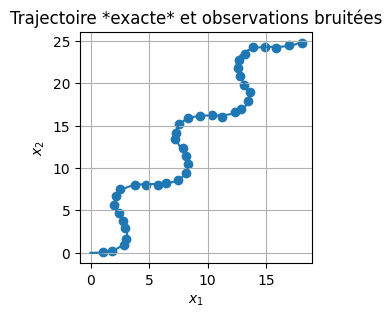

In [4]:
def y_traj(t):
    # on sélectionne les deux premières composantes de la solution "exacte" au temps t : mesure de position exacte
    return sol_traj.sol(t)[:2] 

n_obs = 40

t_obs = np.linspace(0.5,20,n_obs)

sigma_obs = 0.1

y_obs = y_traj(t_obs)
y_obs[0,:] = y_obs[0,:] + np.random.normal(0,sigma_obs,n_obs)
y_obs[1,:] = y_obs[1,:] + np.random.normal(0,sigma_obs,n_obs)

plt.plot(sol_traj.y[0],sol_traj.y[1])
plt.scatter(y_obs[0],y_obs[1])
plt.grid(True)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Trajectoire *exacte* et observations bruitées')
plt.show()


**Question 1. Initialisation et première itération.**

Pour simplifier, on va considérer les composantes connues à $t=0$, soit un vecteur d'état de la forme $x_0 = (0,0,0,2,0)$. 

Initialiser l'ensemble des $N$ particules en $x_0$ et initialiser les poids à $\frac1N$. Perturber les 2 dernières composantes en y additionnant une variable aléatoire gaussienne d'écart type 0.2 puis propager la trajectoire jusqu'au premier pas de temps d'observation en utilisant votre schéma d'Euler.

Calculer les poids des particules et les normaliser.

Rééchantillonner les particules.

On pensera à stocker l'ensemble des trajectoires ainsi que les poids associés.

In [159]:

#   // !! \\ QUELLE FONCTION UTILISEE ( f_traj donne un résultat "parfait" , f_ext est parfait sur la composante x[2] avec np.sin(t))
def f_traj(t,x):
    v = 2.0 
    w = np.sin(t)
    return np.array([v*np.cos(x[2]),v*np.sin(x[2]),w,0,0])
f_traj = np.vectorize(f_traj, excluded=['t'], signature = "(),(m)->(m)")

def f_ext(t,x):
    return np.array([x[3]*np.cos(x[2]),x[3]*np.sin(x[2]),np.sin(t),0,0])
f_ext = np.vectorize(f_ext, excluded=['t'], signature = "(),(m)->(m)")


# Paramètres
x0 = np.array([0.0,0.0,0.,2.,0.0])
N = 200
t = t0
dt = (tf - t0)/n_obs
t = t0
# Paramètres pour le calcul des poids
density = stats.multivariate_normal.pdf
cov_obs = np.array([[0.1,0],
                   [0,0.1]])
cov_perturbations = np.array([[0.2,0],
                   [0,0.2]])

In [6]:
# INITIALISATION DES PARTICULES
# Initialisation
particules = np.full((N,5),x0)
poids = np.full((N), 1/N)

# Bruit gaussien (écart-type = 0.2)
particules[:,3:] += np.random.normal(loc = 0, scale = 0.2, size = (N,2))
#print("bruit gaussien : ", particules)

def one_step_euler_explicit(f, x0, dt, t0):
    return x0+dt*f(t0,x0)
one_step_euler_explicit = np.vectorize(one_step_euler_explicit, excluded=['f',"dt", "t0"], signature = "(),(m,n),(),()->(m,n)")

In [7]:
# 1 ETAPE DE L'ALGO

# Propagation de la trajectoire
particules = one_step_euler_explicit(f_ext, particules, dt, t)
particules[:,:2] += np.random.normal(loc = 0, scale = 0.1, size = (N,2)) # bruit d'observation
t += dt

# Calcul des poids
poids = np.array([density(x[:2] - f_traj(t,x)[:2], cov = cov_obs)/density(x[3:], cov = cov_perturbations) for x in particules])

poids = poids/np.sum(poids)

# Rééchantillonnage
particules = particules[np.random.choice(particules.shape[0],size = N, p = poids), :]
poids = np.full((N), 1/N)

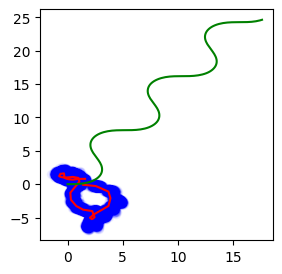

In [163]:
# TEST 
# Initialisation
N = 1000

particules = np.full((N,5),x0)
poids = np.full((N), 1/N)
poids = np.asarray(poids).astype('float64')

# Bruit gaussien (écart-type = 0.2)
particules[:,3:] += np.random.normal(loc = 0, scale = 0.2, size = (N,2))

#print("bruit gaussien : ", particules)

plt.figure()
n_step = n_obs
avg_pos = np.zeros((n_step, 2))
for i in range(n_step):
    particules = one_step_euler_explicit(f_ext, particules, dt, t) # dynamique
    particules[:,:2] += np.random.normal(loc = 0, scale = 0.1, size = (N,2)) # erreur d'observation
    
    # affichage de la pop de particules
    plt.plot(particules[:,0],particules[:,1], linestyle ="", marker = "o", alpha = 0.05, color = "blue")#(i/n_step,0.,0.))
    
    # CALCUL DES POIDS // ! \\ FAUX
    poids = np.array([density(x[:2] - f_traj(t,x)[:2], cov = cov_obs)/density(x[3:] , cov = cov_perturbations) for x in particules]) # calcul des poids
    poids = poids/np.sum(poids) # normalisation
    poids = np.nan_to_num(poids)
    poids[np.argmax(poids)] += 1 - np.sum(poids)

    #print(poids.max()) # Pour visualiser les possibles dérives du nuage de points
    
    # échantillonnage
    # activer le reechantillonnage donne des divergences => CALCUL DES POIDS FAUX
    # l'échantillonnage ne pose pas de problème quand on utilise f_traj
    particules = particules[np.random.choice(particules.shape[0],size = N, p = poids), :] # rééchantillonnage
    
    # REMISE A ZERO DES POIDS POUR LE CALCUL DE LA POSITION MOYENNE CAR LE CALCUL DES POIDS CI DESSUS EST FAUX
    poids = np.full((N), 1/N) # remise à zéro des poids
    avg_pos[i] = np.average(particules, weights = poids, axis = 0)[:2]
    
    
    particules[:,3:] += np.random.normal(loc = 0, scale = 0.2, size = (N,2)) # perturbations des accélérations
    #print(particules)
    
    t += dt

plt.plot(avg_pos[:,0], avg_pos[:,1], color = "red")


# AFFICHAGE DE LA TRAJ THEORIQUE
y_obs = y_traj(t_obs)
y_obs[0,:] = y_obs[0,:] + np.random.normal(0,sigma_obs,n_obs)
y_obs[1,:] = y_obs[1,:] + np.random.normal(0,sigma_obs,n_obs)
plt.plot(sol_traj.y[0],sol_traj.y[1], color = "green")

plt.show()


**Question 2. Implémentation complète** 

Itérer le procédé jusqu'au dernier pas de temps d'observation, $T=20$. (conseil : commencer par implémenter un code avec un nombre de particules assez faible, disons 100 et un nombre de pas d'observation réduit puis augmenter les 2 progressivement pour travailler au final avec plusieurs milliers de particules. Augmenter le nombre de particules permet d'éviter ou au moins de retarder la dégénérescence du nuage de points, c'est-à-dire le fait d'avoir uniquement des poids faibles ce qui rend le rééchantillonnage inopérant.) Représenter le nuage de points final ainsi que la dernière observation.

**Question 3. Représentation graphique** 

Représenter la trajectoire de référence, la trajectoire moyenne (cf. **np.average**) ainsi que les trajectoires correspondant aux quantiles à 2,5% et 97,5% de chacune des composantes, en tenant bien compte des poids associés. Pour calculer les quantiles d'un échantillon pondéré, on pourra se tourner vers des ressources disponibles en ligne. Commenter.

**Question 4. Prédiction** 

Propager les particules jusqu'au temps 21. Les représenter graphiquement. Commenter.

**Question 5. Limitations**

Essayer différentes valeurs d'écarts types d'observation et de perturbation. Commenter.

**Question 6. Amélioration de la loi instrumentale (facultatif)** 

Les performances du filtre particulaire dépendent beaucoup du choix de la densité instrumentale employée. Nous l'avons implémenté avec une simple perturbation des accélérations sans tenir compte de l'observation suivante. Une possibilité est de propager la trajectoire selon le filtre de Kalman étendu entre chacune des observations. Il faudra pour ce faire modifier le code implémenté dans le projet d'équations différentielles pour tenir compte du fait que l'observation n'est pas disponible en chaque pas de temps de discrétisation.